# Time Series Forecasting in Python

This is a Monthly Car Sales data from the year 1960 to 1968. 
#### Goals for this first part is
1. Exploratory data analysis of the time series
2. Explain the time series behaviour in qualitative and quantitative terms to build intuition for model selection
3. Identify the candidate models and possible model parameters that can be used based on the findings in the EDA

## Importing Libraries

In [1]:
# Author: Madhuri Patil
# Version: 1.0
# Date: 14 oct, 2021

import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('tableau-colorblind10')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

print("Pandas Version: ", pd.__version__)
print("NumPy Version: ", np.__version__)
print("Seaborn Version: ", sns.__version__)

Pandas Version:  1.3.3
NumPy Version:  1.21.2
Seaborn Version:  0.11.2


## Importing Dataset

In [2]:
# loading data.
data = pd.read_csv("data\MonthlyCarSales.csv", index_col="Month", parse_dates = True)
data.head()

,Sales
Month,
1960-01-01,6550
1960-02-01,8728
1960-03-01,12026
1960-04-01,14395
1960-05-01,14587


In [3]:
# to set freq of dates.
data = data.asfreq('M', method='ffill')
data.head()

,Sales
Month,
1960-01-31,6550
1960-02-29,8728
1960-03-31,12026
1960-04-30,14395
1960-05-31,14587


In [4]:
# size of data
print("Size: ", data.size)

Size:  107


In [5]:
# Summary Statistics.
data.describe()

,Sales
count,107.000000
mean,14595.280374
std,4546.508812
min,5568.000000
25%,11308.500000
50%,13932.000000
75%,17629.500000
max,26099.000000


### Missing Values

In [6]:
data.isnull().sum()

Sales    0
dtype: int64

### Duplicates

In [7]:
data.duplicated().sum()

0

1. There are no null values
2.  No duplicates present in Series.

## Data Visualization
### 1. Line plot

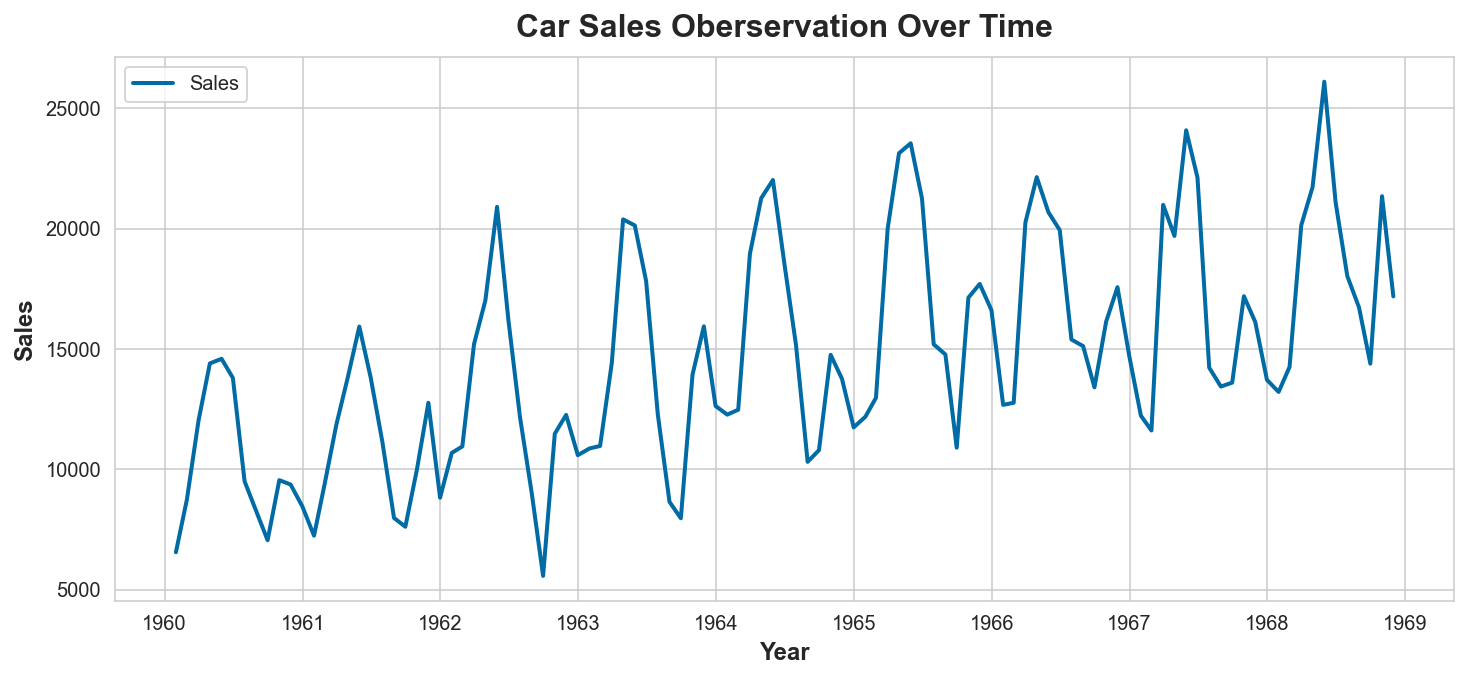

In [8]:
# plot
plt.plot(data, linewidth=2, label="Sales")

plt.xlabel("Year")
plt.ylabel("Sales")
plt.title("Car Sales Oberservation Over Time")

plt.legend()
plt.show()

The above line plot shows that,
1. Time series has **Increasing Trend** of sales over time.
2. There appear to systematic seasonality to the sales for each year.
3. Seasonal signals growing over time.
4. The seasonality suggest that the series is almost non-stationary.

### Box-Whisker plot for distribution and outliers

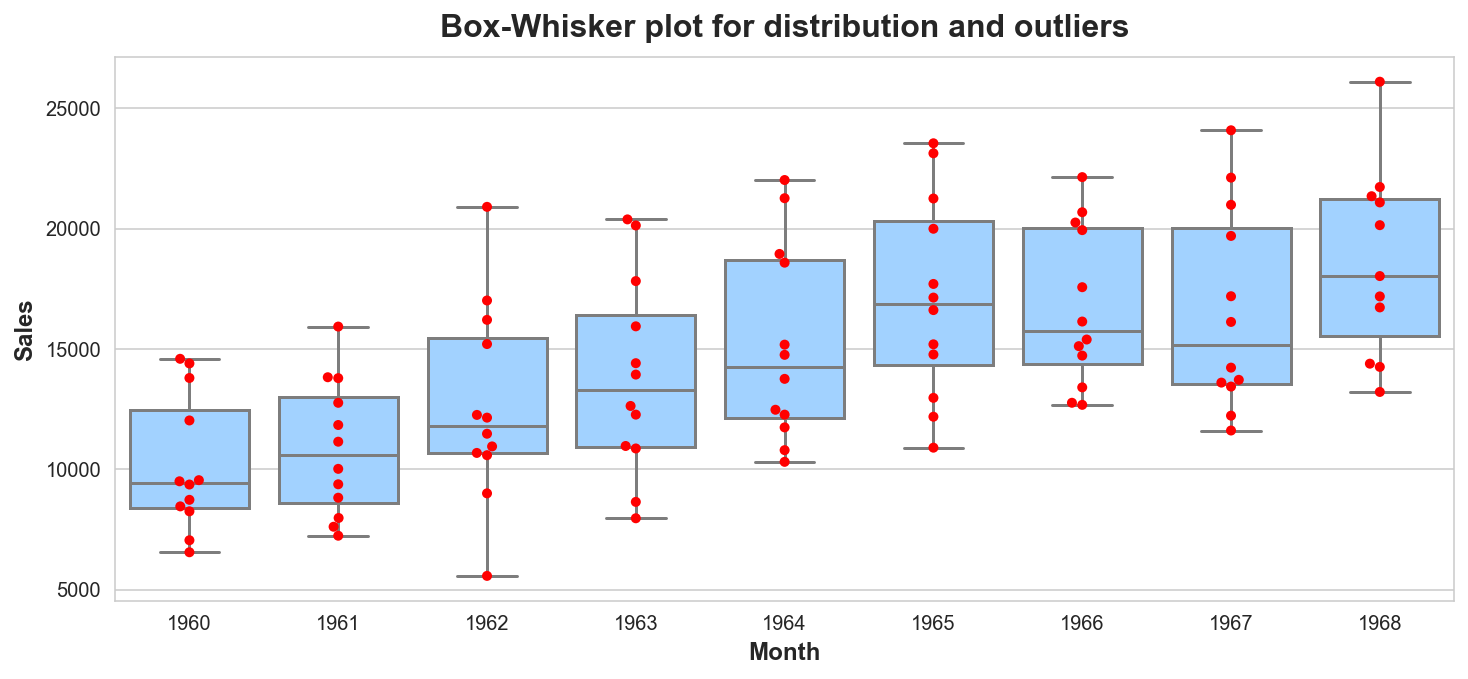

In [9]:
# boxplot
sns.boxplot(data=data, x=data.index.year, y='Sales', color="#A2D2FF", saturation=1.2)
sns.swarmplot(data=data, x=data.index.year, y='Sales', color='red');

plt.title("Box-Whisker plot for distribution and outliers")
plt.show()

1. There are no outliers in data.
2. The median value for each year shows increasing trend in sales till the year 1965. After 1965, there is decrease and increase in Sales values are observed. 

In [42]:
# %Growth in sales each year.
Pergrowth = data.groupby(data.index.year)['Sales'].sum().pct_change()
Pergrowth*100

Month
1960          NaN
1961     6.591132
1962    16.625862
1963     9.188602
1964     9.721377
1965    12.790231
1966    -2.235826
1967    -0.882205
1968     2.605842
Name: Sales, dtype: float64

The series shows some pattern of increasing and decreasing growth of sales value. It appears that there may be some seasonality present.

## Decomposition

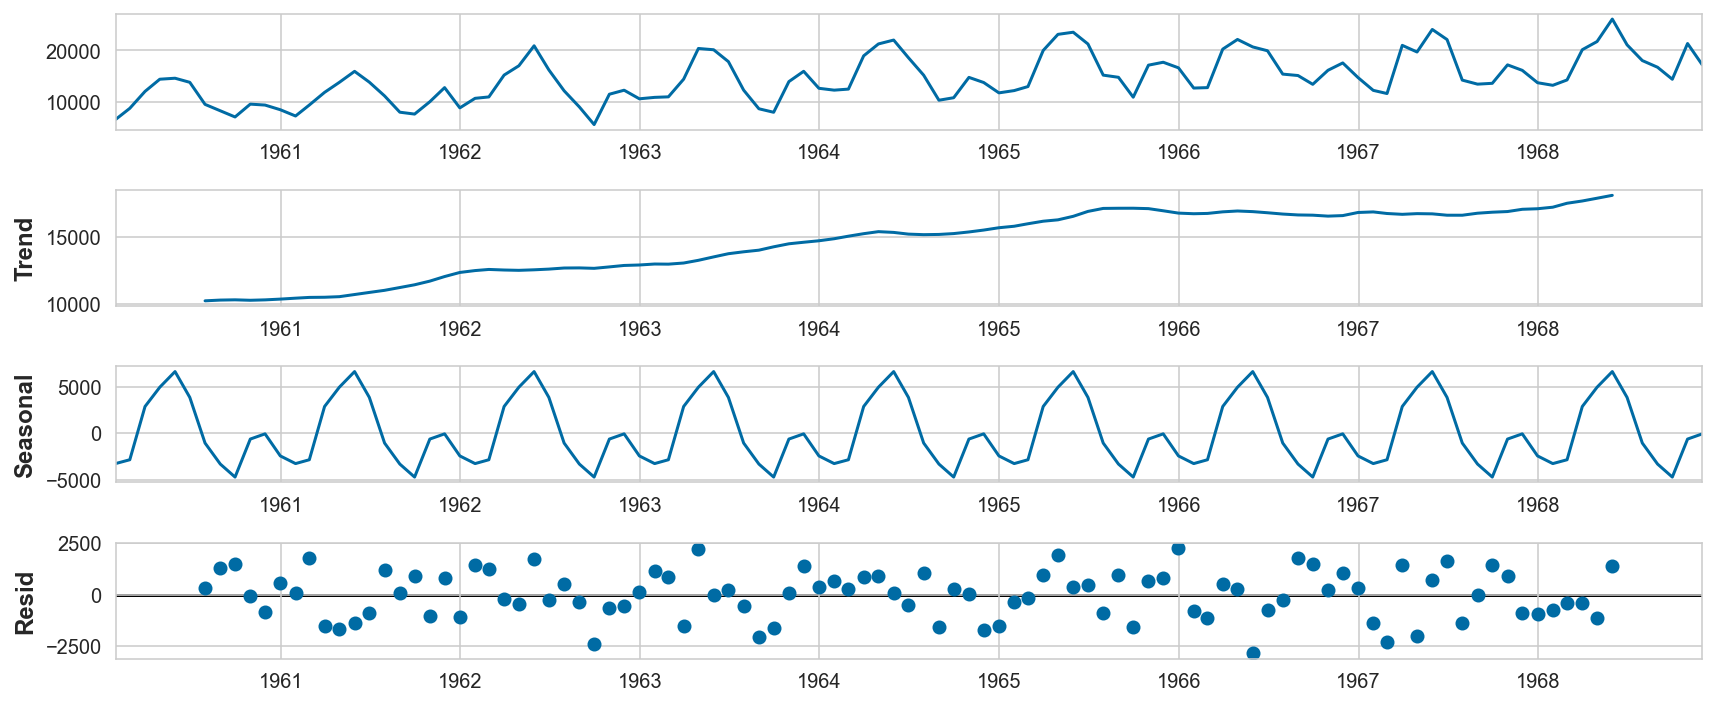

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(data)
decompose.plot();

1. Trend is upward and quite linear.
2. Seasonal pattern is constant over the years.
3. Resduals are left after fitting the trend and seasonal components to the observed data. It's the component we cannot explain. We want the residuals to be i.i.d (i.e uncorrelated). If the residuals have a pattern, it means there is still some structural information left to be captured. Residuals are showing some wavy pattern, which is not good. Let's perform Ljung Box test to confirm if they are i.i.d as a group.

In [50]:
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung

avg_lpval = np.mean(ljung(x = decompose.resid.dropna()))[1].round(3)
p_value = 0.05

if avg_lpval > p_value:
    print("Residuals are uncorrelated.")
else:
    print("Residuals are correlated.")

Residuals are uncorrelated.


Residuals are uncorrelated.
Ljung Box test tests the residuals as a group. Some residuals may have significant lag but as a group, we want to make sure they are uncorrelated. In this case they are uncorrelated so this is good.

## Stationarity
Let's see is the data is stationary or not.

For the series to be stationary it must have
* Constant Mean
* Constant Variance
* Constant Covariance

### Mean and Variance
We will check the statinarity of time series using statistical test called **adfuller test** as well as observing the Rolling mean and variance over the original data.

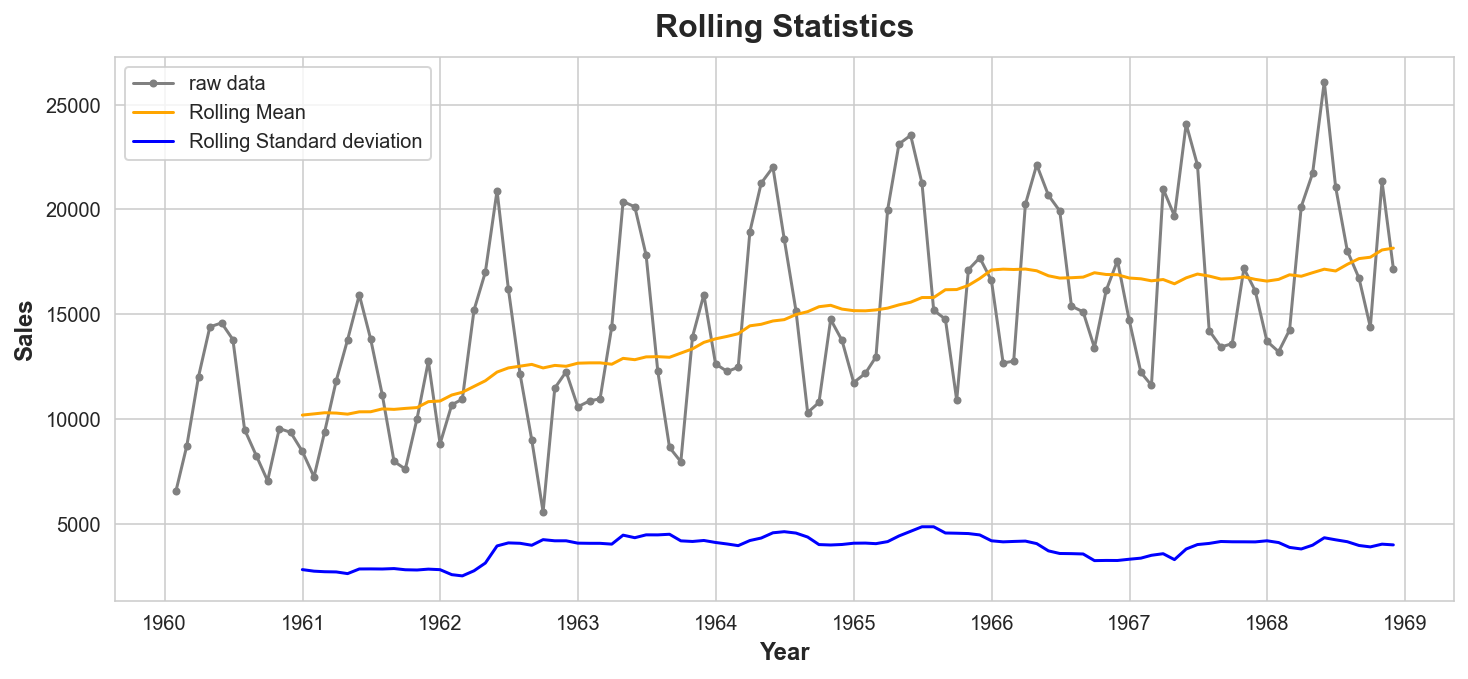

In [51]:
# Rolling statistics to test stationarity of time series data.

def test_stationary(data, title):
    
    # since data has 12 months, consider window=12.
    roll_mean = data.rolling(window=12, center=False).mean()
    roll_std = data.rolling(window=12, center=False).std()
    
    # plots
    plt.plot(data.Sales, color='gray', marker=".", label=title)
    plt.plot(roll_mean, color='orange', label="Rolling Mean");
    plt.plot(roll_std, color='blue', label="Rolling Standard deviation");

    plt.xlabel("Year")
    plt.ylabel("Sales")
    plt.title("Rolling Statistics")
    
    plt.legend()
    plt.show()
    
test_stationary(data, 'raw data')

The rolling statistics plot shows that, Both Standard deviation and Mean is increasing over time. Thus the series is not stationary. Let's check the same using adfuller test.

In [64]:
# adfuller test

from statsmodels.tsa.stattools import adfuller

def adfuller_test(timeseries, title):
    
    print(f"Agumented Dickey-fuller test result of **{title}**")
    result = adfuller(timeseries.dropna(), autolag='AIC')
    
    print("Statistical adf-test value:{:.3f}".format(result[0]))
    print("P-value:{:.3f}".format(result[1]))
    print("Critical Values: ")
    for k, v in result[4].items():
        print('\t{} : {} --> The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<result[0] else '', 100-int(k[:-1])))
        
adfuller_test(data, 'Original Raw Data')

Agumented Dickey-fuller test result of **Original Raw Data**
Statistical adf-test value:-1.108
P-value:0.712
Critical Values: 
	1% : -3.5019123847798657 --> The data is not stationary with 99% confidence
	5% : -2.892815255482889 --> The data is not stationary with 95% confidence
	10% : -2.583453861475781 --> The data is not stationary with 90% confidence


The adfuller test result shows that, the series has p-value of **0.712** which is greater than 0.05, as well as the adfuller test value is greater than critical value. So, the time series is not a stationary. 

### Coefficient of Variation
Coefficient of variation gives us an idea about the variability in the process. 

CV = Standard Deviation / Mean

* if CV < 0.75 --> Low Variability
* if 0.75 < CV < 1.3 --> Medium Variability
* if CV > 1.3 --> High Variability

In [16]:
cv = data.Sales.std() / data.Sales.mean()
cv.round(2)

0.31

CV is less 0.75 so, it is a low-variability process.

## Detrending

This method remove any trend if present in time series.

In [60]:
data.rolling(12).mean()

,Sales
Month,
1960-01-31,NaN
1960-02-29,NaN
1960-03-31,NaN
1960-04-30,NaN
1960-05-31,NaN
...,...
1968-07-31,17381.916667
1968-08-31,17655.916667
1968-09-30,17721.500000


Agumented Dickey-fuller test result of **De-trended Data**
Statistical adf-test value:-1.800
P-value:0.380
Critical Values: 
	1% : -3.5117123057187376 --> The data is not stationary with 99% confidence
	5% : -2.8970475206326833 --> The data is not stationary with 95% confidence
	10% : -2.5857126912469153 --> The data is not stationary with 90% confidence


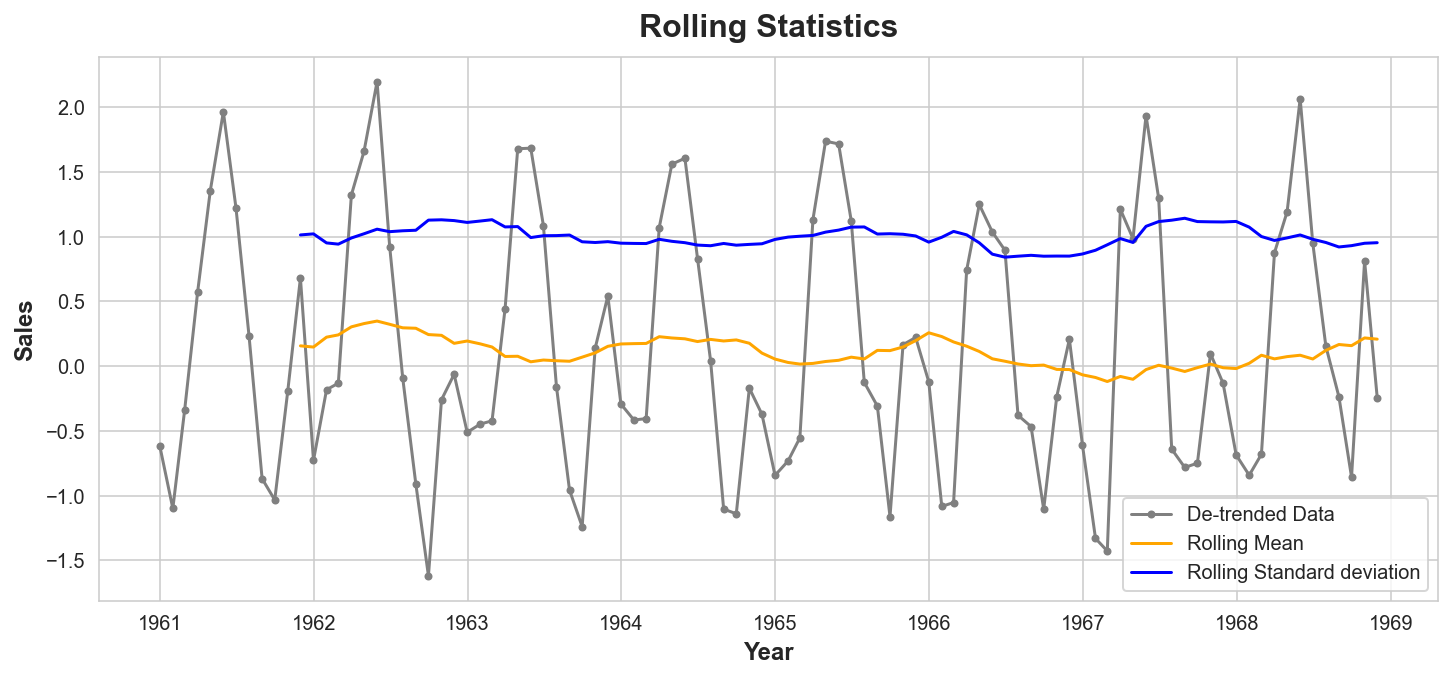

In [61]:
# De-trending
de_trended = (data - data.rolling(12).mean()) / data.rolling(12).std()
    
# check if the de-trended data is stationary or not.
adfuller_test(de_trended, 'De-trended Data')
test_stationary(de_trended, 'De-trended Data')

Both graph and adfuller test shows that De-trended data is not sationary.

## Differencing

This method removes the underlying seasonal or cyclical patterns in the time series.

Agumented Dickey-fuller test result of **Detrended Data**
Statistical adf-test value:-6.090
P-value:0.000
Critical Values: 
	1% : -3.5019123847798657 --> The data is  stationary with 99% confidence
	5% : -2.892815255482889 --> The data is  stationary with 95% confidence
	10% : -2.583453861475781 --> The data is  stationary with 90% confidence


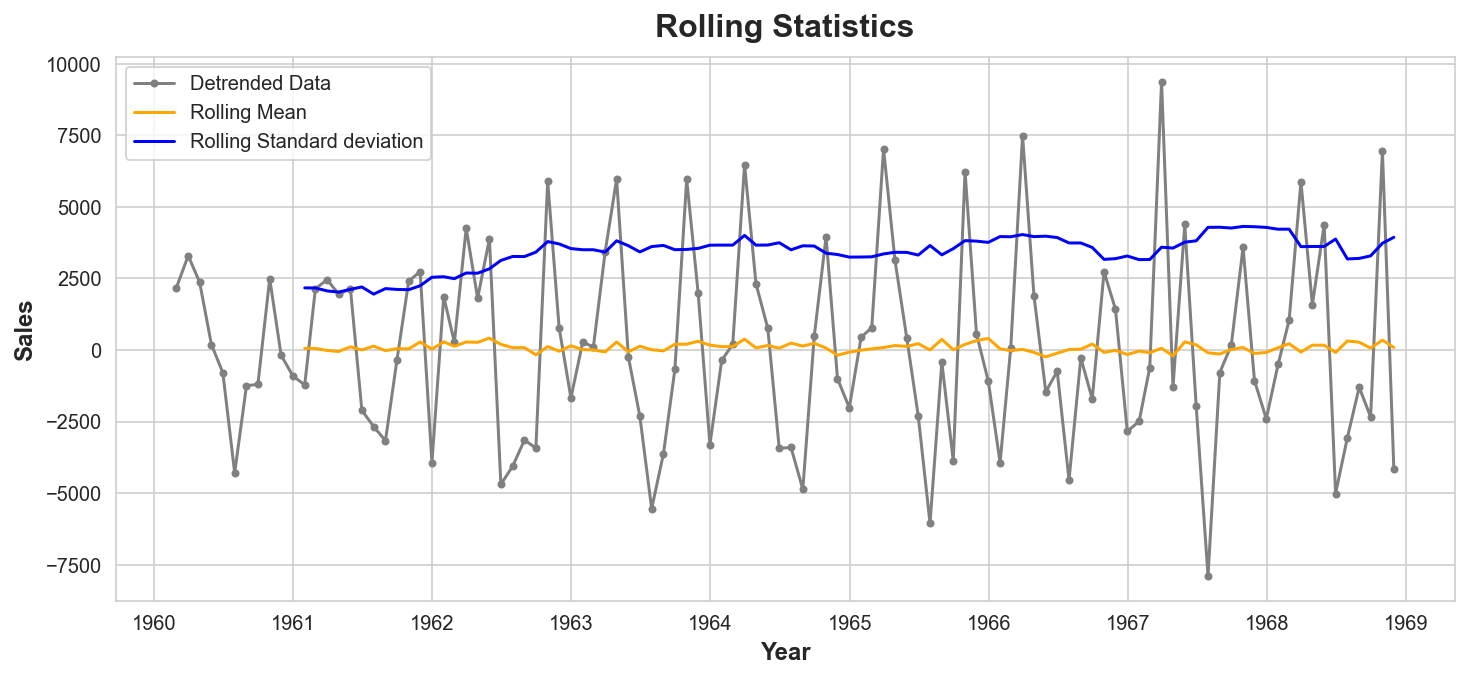

In [71]:
# differencing
data_12lag = data - data.shift()

# check again if this series is stationary or not.
adfuller_test(data_12lag, 'Detrended Data')
test_stationary(data_12lag, 'Detrended Data')

Differencing Data is stationary.

## Combining detrending and differencing.

Agumented Dickey-fuller test result of **12 lag Difference Detrended Data**
Statistical adf-test value:-4.123
P-value:0.001
Critical Values: 
	1% : -3.512738056978279 --> The data is  stationary with 99% confidence
	5% : -2.8974898650628984 --> The data is  stationary with 95% confidence
	10% : -2.585948732897085 --> The data is  stationary with 90% confidence


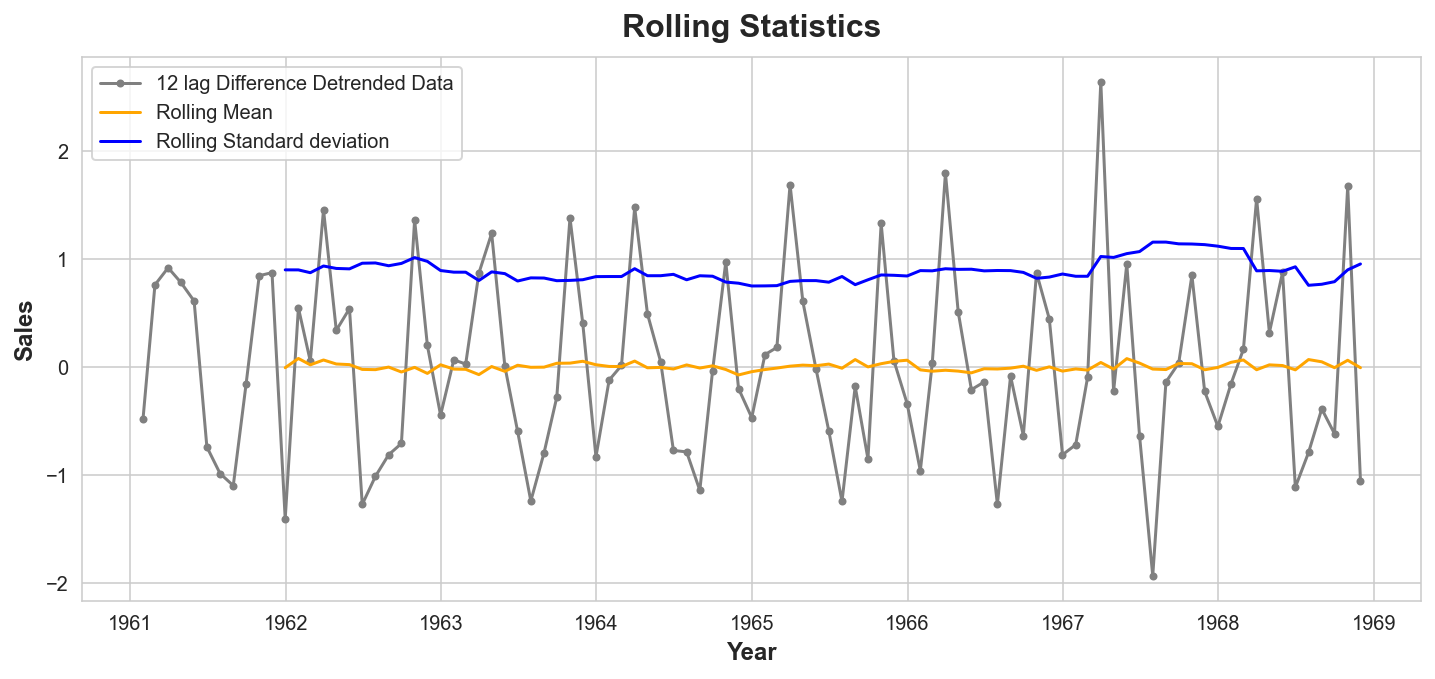

In [67]:
# de-trending + differencing.
data_12lag_detrend = de_trended - de_trended.shift()

# check again if this series is stationary or not.
adfuller_test(data_12lag_detrend, '12 lag Difference Detrended Data')
test_stationary(data_12lag_detrend, '12 lag Difference Detrended Data')

Using the combination of the two methods, we see from both the visualization and the ADF test that the data is now stationary. Combination of detrend and difference performs better. So, let's consider this time series for further analysis.

### Lag plot

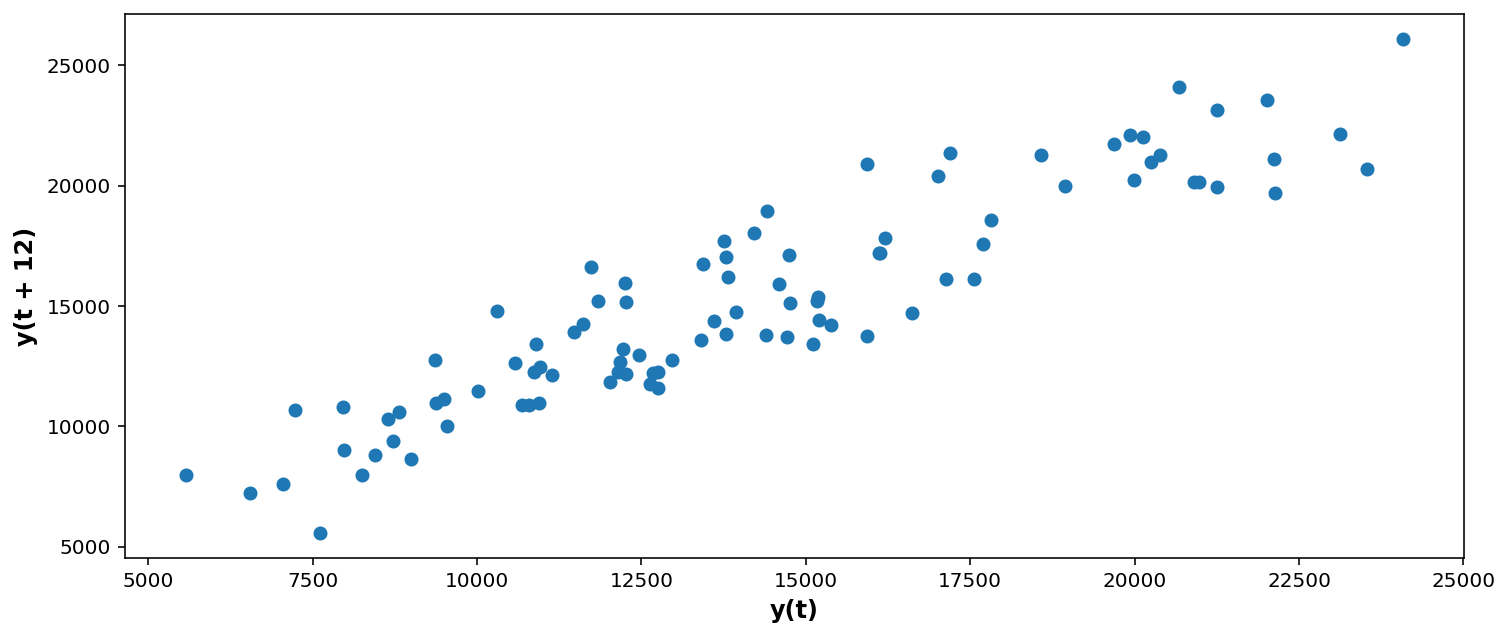

In [22]:
# 12th lag
pd.plotting.lag_plot(data.Sales, 12);

# same can be plot using sns
# sns.scatterplot(data.Sales, data.Sales.shift(-1));

These are scatter plots of data['Sales'] against its 12th lags. It shows strong linear relationship.

## To check data is normally distributed or not

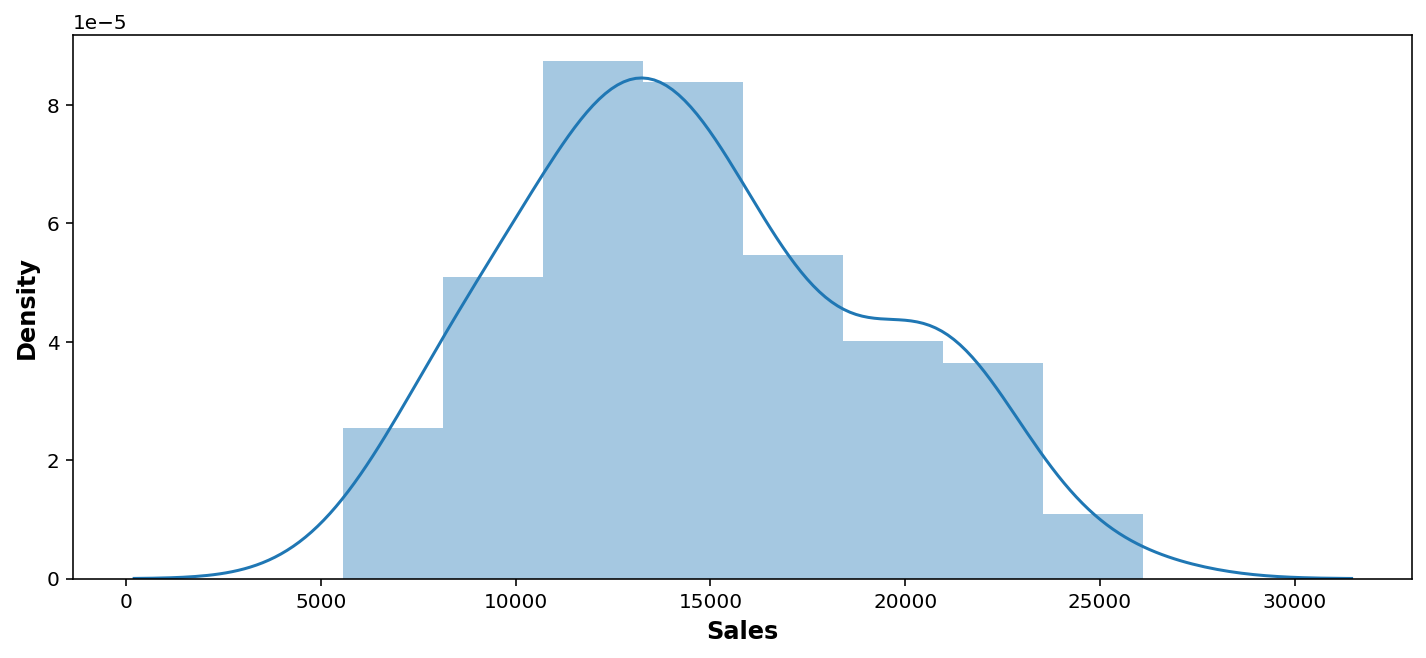

In [24]:
import warnings
warnings.filterwarnings('ignore')

sns.distplot(data.Sales);

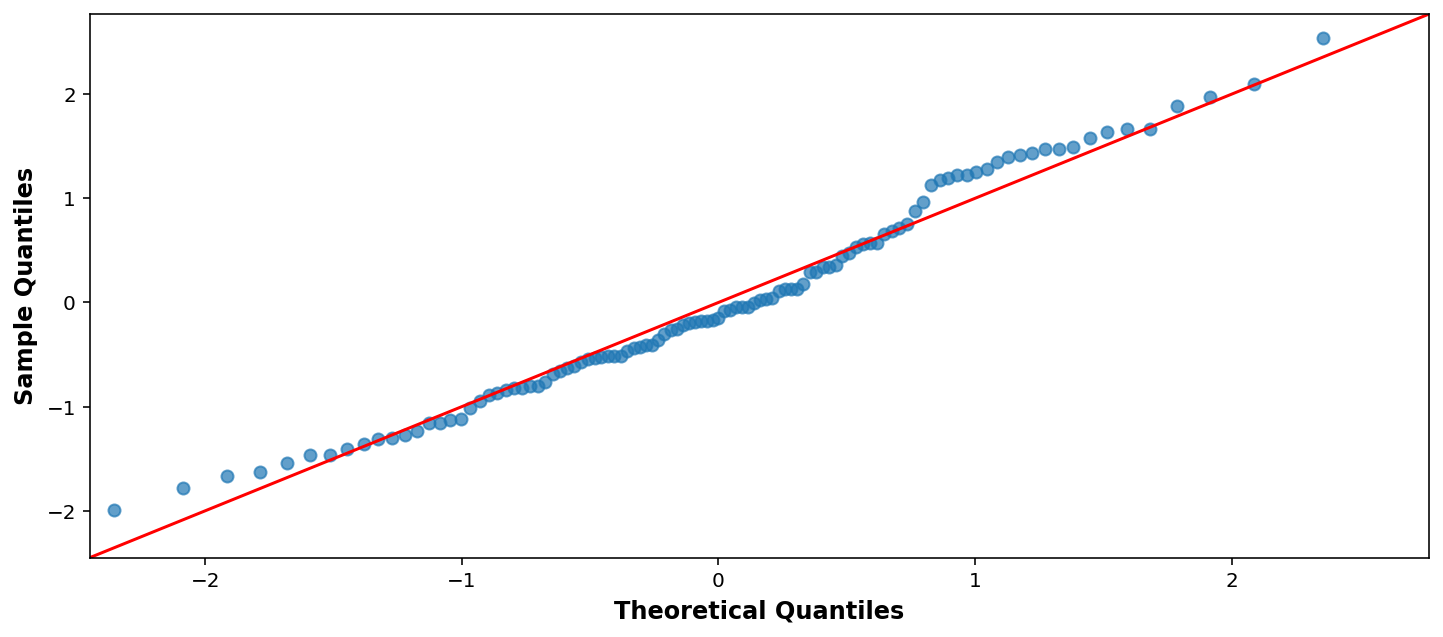

In [25]:
#Q-Q plot
import statsmodels.api as sm
sm.qqplot(data.Sales, fit=True, line='45', alpha=0.7);

Q-Q plot shows the data follows the 45deg line very closely, deviates slightly in left tail.

In [26]:
from scipy.stats import jarque_bera as jb
is_norm = jb(data.Sales)[1]
print(f"p value:{is_norm.round(2)}","series is normal" if is_norm > 0.05 else "Series is not normal")

p value:0.17 series is normal


Jarque  Bera test shows the data is from Normal distribution.

In [75]:
# # acf and pacf plot
# from statsmodel.tsa.statstools import plot_acf, plot_pacf